In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd

from fiesta.plot import latex_labels


## Time-dependent systematic uncertainty

Load the data

In [2]:
posterior_pbag = pd.DataFrame(dict(np.load("./pbag/posterior.npz")))
posterior_pbag["thetaWing"] = posterior_pbag["thetaCore"] * posterior_pbag["alphaWing"]
posterior_afgpy = pd.DataFrame(dict(np.load("./afgpy/posterior.npz")))
posterior_afgpy["thetaWing"] = posterior_afgpy["alphaWing"] * posterior_afgpy["thetaCore"]

Make corner plot

In [3]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "thetaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B"]
labels = [latex_labels.get(p, p) for p in var_names]

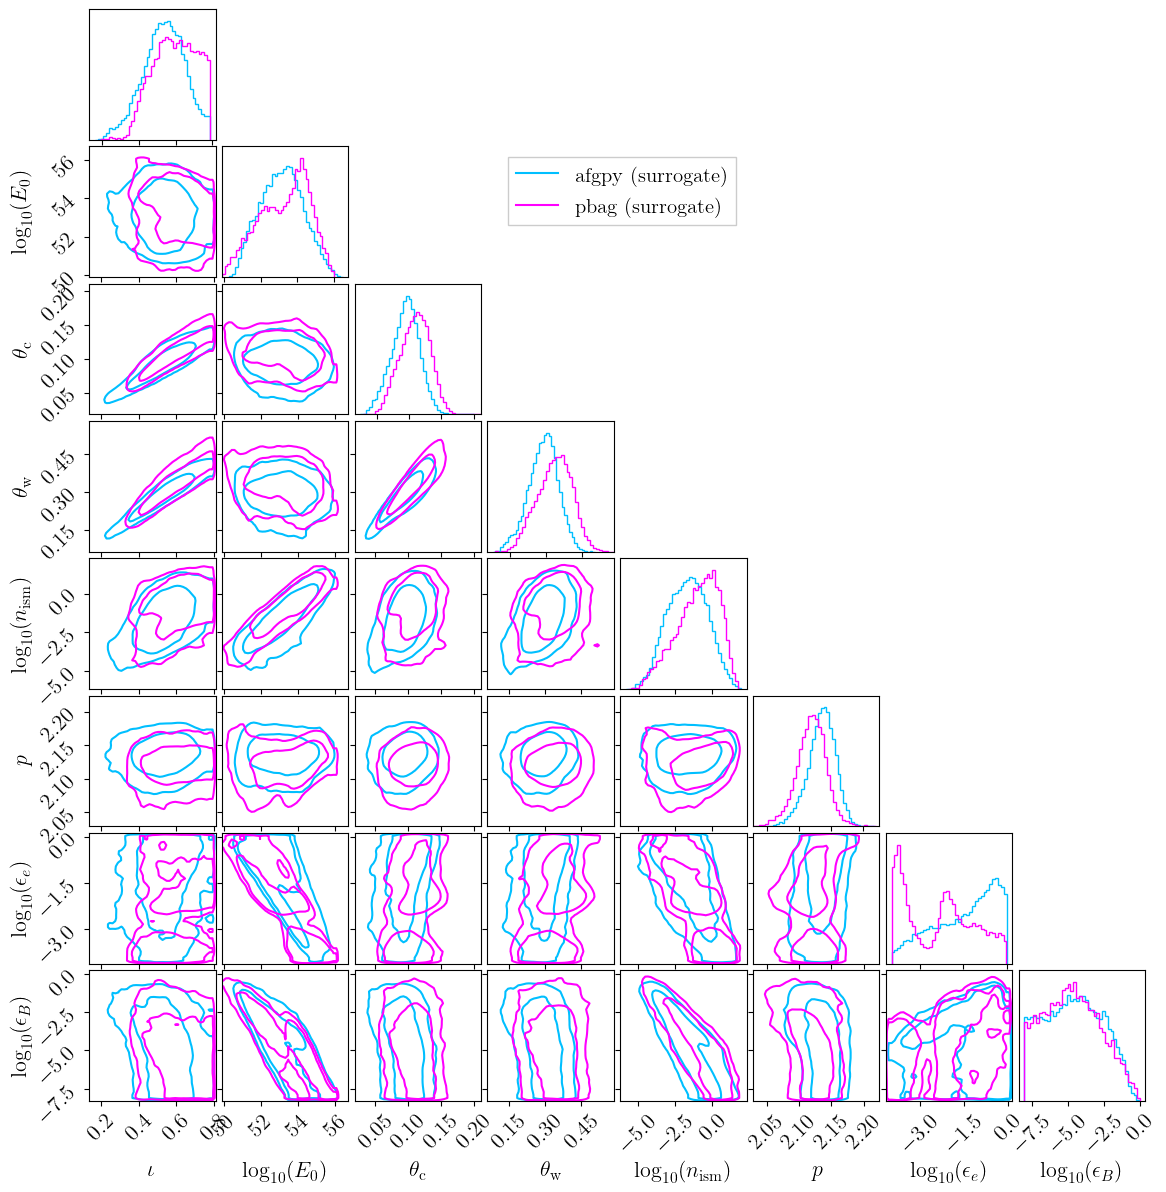

In [5]:
fig, ax = plt.subplots(len(var_names), len(var_names), figsize = (12, 12))

corner.corner(posterior_afgpy[var_names], 
              fig=fig,
              color = "deepskyblue",
              labelpad = 0.15,
              labels =  labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

corner.corner(posterior_pbag[var_names],
              fig=fig,
              color="magenta",
              labelpad = 0.15,
              labels =  labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

handles = []
for c in ["deepskyblue", "magenta"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[1, 4].legend(handles=handles, labels=["afgpy (surrogate)", "pbag (surrogate)"], fontsize=15, fancybox=False, framealpha=1)
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99)
plt.show()

# Check surrogate lightcurve

In [14]:
from fiesta.inference.prior import Uniform, Constraint
from fiesta.inference.prior_dict import ConstrainedPrior
from fiesta.inference.fiesta import Fiesta
from fiesta.inference.likelihood import EMLikelihood
from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.utils import load_event_data

from fiesta.train.AfterglowData import RunAfterglowpy

In [ ]:
########
# DATA #
########

data = load_event_data("../../data/GRB170817A.dat")
trigger_time = 57982.52851852
FILTERS = data.keys()

#########
# MODEL #
#########

model = AfterglowFlux(name="afgpy_gaussian_CVAE",
                      filters = FILTERS)


11:21 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
INFO:fiesta:Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
11:21 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
INFO:fiesta:	 inclination_EM: (0, 1.5707963267948966)
11:21 fiesta INFO    : 	 log10_E0: (47, 57)
INFO:fiesta:	 log10_E0: (47, 57)
11:21 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
INFO:fiesta:	 thetaCore: (0.01, 0.6283185307179586)
11:21 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
INFO:fiesta:	 alphaWing: (0.2, 3.5)
11:21 fiesta INFO    : 	 log10_n0: (-6, 2)
INFO:fiesta:	 log10_n0: (-6, 2)
11:21 fiesta INFO    : 	 p: (2.01, 3)
INFO:fiesta:	 p: (2.01, 3)
11:21 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
INFO:fiesta:	 log10_epsilon_e: (-4, 0)
11:21 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
INFO:fiesta:	 log10_epsilon_B: (-8, 0)
11:21 fiesta INFO    : Surrogate af

In [79]:
samples = np.load("./afgpy/results_production.npz")["chains"].reshape(-1, 9)
log_prob = np.load("./afgpy/results_production.npz")["log_prob"].reshape(-1,)
mask = samples[:,0]>1.2


ind = np.argsort(log_prob[mask])[-1]
params = dict(zip(model.parameter_names, samples[mask][ind]))
print(params)
X = np.array([samples[mask][ind]])

{'inclination_EM': 1.3928463, 'log10_E0': 53.066536, 'thetaCore': 0.24683891, 'alphaWing': 3.1182163, 'log10_n0': 1.9540533, 'p': 2.1550372, 'log10_epsilon_e': -1.3711071, 'log10_epsilon_B': -7.228824}


In [ ]:
###############
# AFTERGLOWPY #
###############


afgpy = RunAfterglowpy(0, model.times, model.nus, X, parameter_names=model.parameter_names)
_, mJys = afgpy(0)
mJys = np.exp(mJys).reshape(len(model.nus), len(model.times))

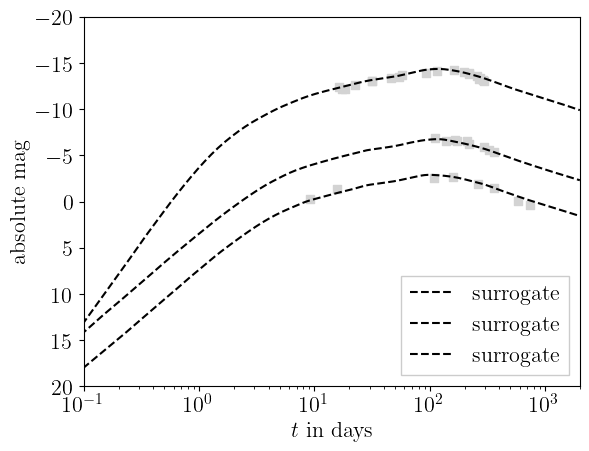

In [ ]:
_, pred_mag = model.predict_abs_mag(params)

for Filt in model.Filters[:3]:
    plt.plot(model.times, Filt.get_mag(mJys, model.nus), label=Filt.name)
    plt.plot(model.times, pred_mag[Filt.name], color="black", linestyle="dashed", label="surrogate")
    plt.scatter(data[Filt.name][:,0] - 57982.52851852, data[Filt.name][:,1] - 5*(np.log10(43*1e6)-1), marker="s", color="lightgrey")
    plt.xscale("log")
    plt.xlim(0.1, 2000)
    plt.ylim(-20, 20)
    plt.xlabel("$t$ in days")
    plt.ylabel("absolute mag")

plt.legend(fancybox=False, framealpha=1)
plt.gca().invert_yaxis()



In [67]:
samples = np.load("./afgpy/results_production.npz")["chains"].reshape(-1, 9)
log_prob = np.load("./afgpy/results_production.npz")["log_prob"].reshape(-1,)
mask = samples[:,0]<1.2


ind = log_prob[mask].argmax()
params = dict(zip(model.parameter_names, samples[mask][ind]))
print(params)
X = np.array([samples[mask][ind]])

{'inclination_EM': 0.36262065, 'log10_E0': 53.03262, 'thetaCore': 0.059803586, 'alphaWing': 3.4285772, 'log10_n0': -3.0439792, 'p': 2.1210535, 'log10_epsilon_e': -2.313587, 'log10_epsilon_B': -2.2309036}


In [104]:
samples = np.load("./afgpy/results_production.npz")["chains"].reshape(-1, 9)
log_prob = np.load("./afgpy/results_production.npz")["log_prob"].reshape(-1,)
mask = samples[:,0]>1.2


ind = np.argsort(log_prob[mask])[-1000:]
params = dict(zip(model.parameter_names, samples[mask][ind].T))

In [105]:
params["redshift"] = np.zeros(1000)
params["luminosity_distance"] = np.ones(1000)* 43
_, pred_mag = model.vpredict(params)

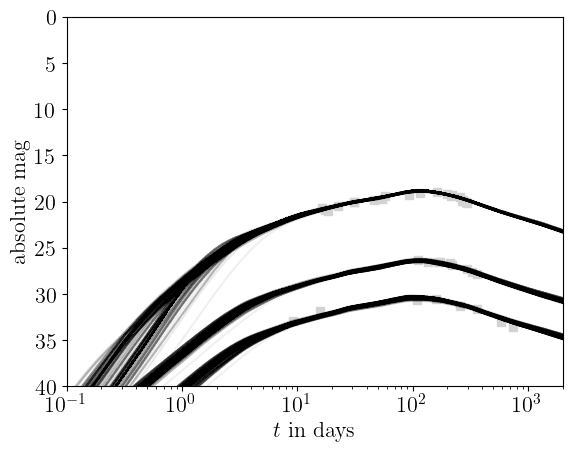

In [106]:
for Filt in model.Filters[:3]:
    for j in range(1000):
        plt.plot(model.times, pred_mag[Filt.name][j], color="black", linestyle="solid", alpha=0.02)
    plt.scatter(data[Filt.name][:,0] - 57982.52851852, data[Filt.name][:,1], marker="s", color="lightgrey")
    plt.xscale("log")
    plt.xlim(0.1, 2000)
    plt.ylim(0, 40)
    plt.xlabel("$t$ in days")
    plt.ylabel("absolute mag")

#plt.legend(fancybox=False, framealpha=1)
plt.gca().invert_yaxis()

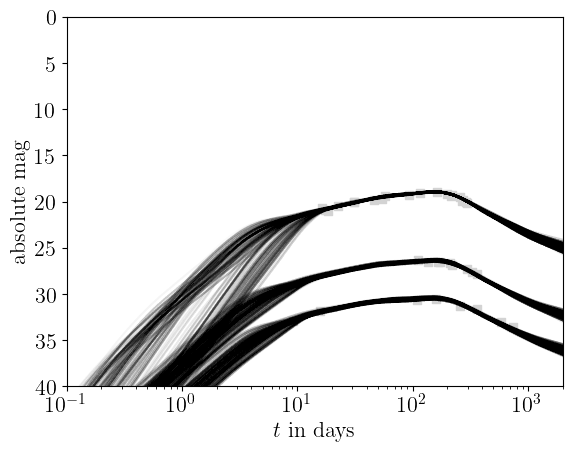